In [19]:
import sys
import os
if not any(path.endswith('textbook') for path in sys.path):
    sys.path.append(os.path.abspath('../../..'))
from textbook_utils import *

In [20]:
csv_file = 'data/Full24hrdataset.csv'
usecols = ['Date', 'ID', 'region', 'PM25FM', 'PM25cf1', 'RH']
full = (pd.read_csv(csv_file, usecols=usecols, parse_dates=['Date'])
        .dropna())
full.columns = ['date', 'id', 'region', 'pm25aqs', 'pm25pa', 'rh']

bad_dates = ['2019-08-21', '2019-08-22', '2019-09-24']
GA = full.loc[(full['id'] == 'GA1') & (~full['date'].isin(bad_dates)) , :]

(sec:linear_multi)=
# Multiple Linear Model

So far in this chapter, we've used a single input variable to predict an outcome variable.
Now we introduce the *multiple linear model* that uses
more than one feature to predict (or describe or explain) the outcome.
Having multiple explanatory features can improve our model's fit to the data and improve predictions.

We start by generalizing from a simple linear model to one that includes a second explanatory variable, called $v$. This model is linear in both $x$ and $v$; meaning that for a pair of values for $x$ and $v$, we can describe, explain, or predict $y$ by the linear combination: 

$$ y \approx \theta_0 + \theta_1 x + \theta_2 v$$

Notice that for a particular value of $v$, say $v^\star$, we can re-express the preceding equation as:

$$ y \approx (\theta_0 + \theta_2 v^\star) ~+~ \theta_1 x$$

In other words, when we hold $v$ constant at $v^\star$, we have a simple linear relation between $x$ and $y$ with slope $\theta_1$ and intercept $\theta_0 + \theta_2 v^\star$. 
For a different value of $v$, say $v^\dagger$,  we again have a simple linear relationship between $x$ and $y$. The slope for $x$ remains the same and the only change is the intercept, which is now $\theta_0 + \theta_2v^\dagger$.

With multiple linear regression, we need to remember to interpret the coefficient $\theta_1$ of $x$ in the presence of the other variables in the model. Holding fixed the values of the other variables in the model (that's just $v$ in this case), an increase of 1 unit in $x$ corresponds to a $\theta_1$ change in $y$, on average. One way to visualize this kind of multiple linear relationship is to create facets of scatter plots of $(x, y)$ where in each plot the values of $v$ are roughly the same. We make such a scatter plot for the air quality measurements next, and provide examples of additional visualizations and statistics to examine when fitting a multiple linear model.    

The scientists who studied the air quality monitors (see {numref}`Chapter %s <ch:pa>`) were looking for an improved model that incorporated weather factors.
One weather variable they examined was a daily measurement for relative humidity.  Let's consider a two-variable linear model to explain the PurpleAir measurements based on the AQS sensor measurements and relative humidity. This model has the following form:

$$ PA \approx \theta_0 + \theta_1 AQ + \theta_2 RH$$

where $PA$, $AQ$, and $RH$ refer to the variables: the PurpleAir average daily measurement, AQS measurement, and relative humidity, respectively.

For a first step, we make a facet plot to compare the relationship between the two air quality measurements for fixed values of humidity. To do this, we transform relative humidity to a categorical variable so that each facet consists of observations with similar humidity:

In [21]:
rh_cat = pd.cut(GA['rh'], bins=[43,50,55,60,78], 
                labels=['<50','50-55','55-60','>60'])

Then we use this qualitative feature to subdivide the data into a two-by-two panel of scatterplots: 

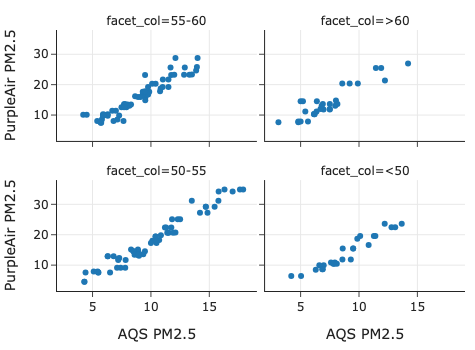

In [32]:
fig = px.scatter(GA, x='pm25aqs', y='pm25pa', 
                 facet_col=rh_cat, facet_col_wrap=2,
                 facet_row_spacing=0.15,
                 labels={'pm25aqs':'AQS PM2.5', 'pm25pa':'PurpleAir PM2.5'},
                 width=550, height=350)

fig.update_layout(margin=dict(t=30))
fig.show()

These four plots show a linear relationship between the two sources of air quality measurements. And the slopes appear to be similar, which means that a multiple linear model may fit well. It's difficult to see from these plots if the relative humidity affects the intercept much. 

We also want to examine the pairwise scatterplots between the three features. When two explanatory features are highly correlated, their coefficients in the model may be unstable.  While linear relationships between three or more features may not show up in pairwise plots, it's still a good idea to check:  

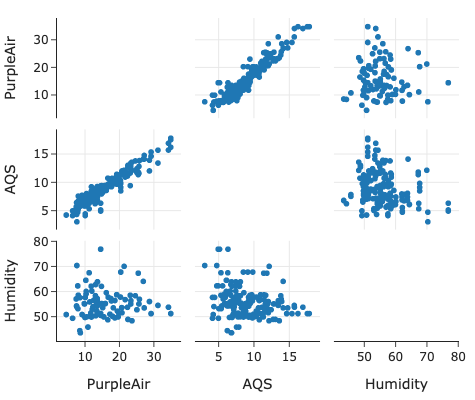

In [33]:
fig = px.scatter_matrix(
    GA[['pm25pa', 'pm25aqs', 'rh']],
    labels={'pm25aqs':'AQS', 'pm25pa':'PurpleAir', 'rh':'Humidity'},
    width=550, height=400)

fig.update_traces(diagonal_visible=False)

The relationship between humidity and air quality does not appear to be particularly strong. Another pairwise measure we should examine are the correlations between features: 

In [24]:
GA[['pm25pa', 'pm25aqs', 'rh']].corr()

,pm25pa,pm25aqs,rh
pm25pa,1.00,0.95,-0.06
pm25aqs,0.95,1.00,-0.24
rh,-0.06,-0.24,1.00


One small surprise is that relative humidity has a small negative correlation with the AQS measurement of air quality. This suggests that humidity might be helpful in the model.


In the next section, we derive the equation for the fit. But for now, we use the functionality in `LinearRegression`  to fit the model. The only change from earlier is that we provide two columns for the explanatory variables (that's why the `x` input is a data frame):

In [25]:
from sklearn.linear_model import LinearRegression

y = GA['pm25pa']
X2 = GA[['pm25aqs', 'rh']]

model2 = LinearRegression().fit(X2, y)

The fitted multiple linear model, including the coefficient units, is:

In [26]:
print(f"PA estimate = {model2.intercept_:.1f} ppm +", 
      f"{model2.coef_[0]:.2f} ppm/ppm x AQS + ",  
      f"{model2.coef_[1]:.2f} ppm/percent x RH")

PA estimate = -15.8 ppm + 2.25 ppm/ppm x AQS +  0.21 ppm/percent x RH


The coefficient for humidity in the model adjusts the air quality prediction by 0.21 ppm for each percentage point of relative humidity. Notice that the coefficient for AQS differs from the simple linear model that we fitted earlier. This happens because the coefficient reflects the additional information coming from relative humidity.

Lastly, to check the quality of the fit, we make residual plots of the predicted values and the errors. This time, we use `LinearRegression` to compute the predictions for us:

In [27]:
predicted_2var = model2.predict(X2)
error_2var = y - predicted_2var

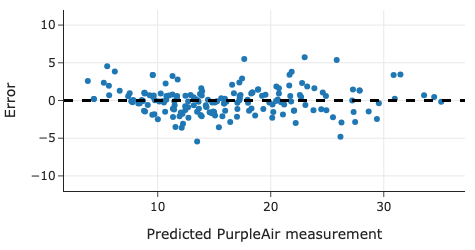

In [28]:
fig = px.scatter(y = error_2var, x=predicted_2var,
                 labels={"y": "Error", "x": "Predicted PurpleAir measurement"},
                 width=350, height=250)

fig.update_yaxes(range=[-12, 12])
fig.add_hline(0, line_width=3, line_dash='dash', opacity=1)

fig.show()

The residual plot appears to have no clear patterns, which indicates that the model fits pretty well. Notice also that the errors nearly all fall within –4 and +4 ppm, a smaller range than in the simple linear model. And we find the standard deviation of the residuals is quite a bit smaller: 

In [29]:
error_2var.std()

1.8211427707294048

The residual standard deviation has been reduced from 2.8 ppm in the one variable model to 1.8 ppm, a good size reduction. 

The correlation coefficient can't capture the strength of a linear association model when we have more than one explanatory variable. Instead, we adapt the MSE to give us a sense of model fit. In the next section, we describe how to fit a multiple linear model and use the MSE to assess fit. 